In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import optimization_SPDC as opt
import optimization_SPDC_gaussain_pump as gauss_opt
import jax.scipy.optimize as jax_opt

key = jax.random.PRNGKey(0)
np.random.seed(0)

In [13]:
# power of the pump
Np = 0.02
# create the frequency matrix ω-ω_mean 
N = 701
wi = -7
wf = 7
x = np.linspace(wi, wf, N)
# get the group velocities for all modes
vp = 0.1
sigma = 1
a = 1.61/1.13
l = 1
def symmetric_v(vp, sigma, l, a):
    vi = vp / (1 - 2 * a * vp / (l * sigma))
    vs = vp / (1 + 2 * a * vp / (l * sigma))
    return vs, vi
vs, vi = symmetric_v(vp, sigma, l, a)
# prefactor to multiply pump with to obtain F matrix
alpha = np.sqrt(Np)*(x[len(x) - 1] - x[0])/(len(x) - 1)/(np.sqrt(2 * np.pi * vs * vi * vp))
# initialize the G and H matrices without cross phase modulation
G = np.diag((1/vs - 1/vp)*x)
H = np.diag((1/vi - 1/vp)*x)
w = np.linspace(2*wi, 2*wf, 2*N)

In [3]:
y_K = 1
y_N = 1

In [14]:
def get_total_loss(a, size: int, alpha, G, H, l, y_N, y_K):
    loss_K = opt.get_euclidean_loss_K(a, size, alpha, G, H, l, y_K)
    loss_N = opt.get_euclidean_loss_N(a, size, alpha, G, H, l, y_N)
    return loss_K + loss_N
def get_total_loss_gaussian(theta, w, alpha, G, H, l, y_N, y_K):
    loss_K = gauss_opt.get_euclidean_loss_K(theta, w, alpha, G, H, l, y_K)
    loss_N = gauss_opt.get_euclidean_loss_N(theta, w, alpha, G, H, l, y_N)
    return loss_K + loss_N

In [17]:
a = []
a.append(0.2/jnp.cosh((jnp.linspace(2*wi, 2*wf, 2*N))**2))
a.append(1/jnp.cosh((jnp.linspace(2*wi, 2*wf, 2*N))**2))
a = jnp.array(a)
a = jnp.reshape(a, 2*len(a[0]))
optimized = jax_opt.minimize(get_total_loss, a, args = (N, alpha, G, H, l, y_N, y_K), method = "BFGS")

In [ ]:
a = 0.1*jnp.ones(4*N)
optimized = jax_opt.minimize(get_total_loss, a, args = (N, alpha, G, H, l, y_N, y_K), method = "BFGS")

In [18]:
theta = jnp.array([1., 1., jnp.pi*2/7])
optimized_gauss = jax_opt.minimize(get_total_loss_gaussian, theta, args = (w, alpha, G, H, l, y_N, y_K), method = "BFGS") 

In [19]:
optimized_a = optimized.x
complex_a = opt.get_complex_array(optimized_a)
optimized_gauss_pump = (optimized_gauss.x)[0]*jnp.exp(-(((optimized_gauss.x)[1])*w)**2)*jnp.exp(1j*(optimized_gauss.x)[2])
a = opt.get_complex_array(a)

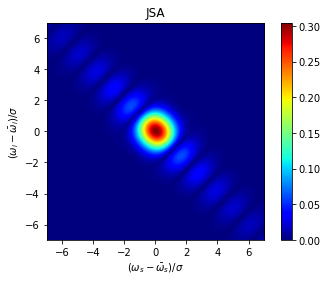

optimized gauss: (DeviceArray(1.005944, dtype=float32), DeviceArray(1.1339204, dtype=float32))
optimized pump:  (DeviceArray(1.0060694, dtype=float32), DeviceArray(1.1336219, dtype=float32))


In [11]:
theta_low = np.array([0.75,0.68,0])
JSA = gauss_opt.get_JSA(optimized_gauss.x, w, alpha, G, H, l)
fig, ax = plt.subplots()
im = ax.imshow(JSA, cmap="jet", origin="lower",extent=[x[0],x[N-1],x[0],x[N-1]])
ax.set_title("JSA")
ax.set_xlabel(r"$(\omega_{s}-\bar{\omega}_{s})/\sigma$")
ax.set_ylabel(r"$(\omega_{i}-\bar{\omega}_{i})/\sigma$")
plt.colorbar(im, orientation="vertical")
plt.show()
#fig.savefig("optimized_gauss_10_N.png")
print("optimized gauss:", gauss_opt.get_observable(optimized_gauss.x, w, alpha, G, H, l))
print("optimized pump: ", opt.get_observables(optimized.x, N, alpha, G, H, l))

In [12]:
alpha*optimized_gauss.x[0]

DeviceArray(0.01162907, dtype=float32)

In [20]:
alpha*optimized_gauss.x[0]

DeviceArray(0.33999887, dtype=float32)

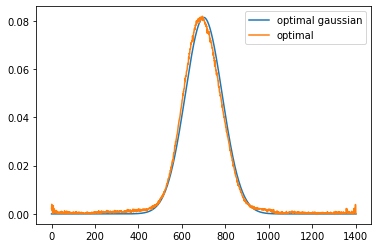

In [17]:
# Get the plot of  absolute norm of a
plt.plot(jnp.abs(optimized_gauss_pump/jnp.linalg.norm(optimized_gauss_pump)), label = "optimal gaussian")
plt.plot(jnp.abs(complex_a)/jnp.linalg.norm(jnp.abs(complex_a)), label = "optimal")
plt.legend()

In [18]:
normalized_gaussian_pump = optimized_gauss_pump/jnp.linalg.norm(optimized_gauss_pump)
normalized_optimal_pump = complex_a/ jnp.linalg.norm(complex_a)
normalized_a = a/jnp.linalg.norm(a)

In [19]:
jnp.abs(jnp.vdot(normalized_gaussian_pump, normalized_optimal_pump)),jnp.abs(jnp.vdot(normalized_a, normalized_optimal_pump))

(DeviceArray(0.9959479, dtype=float32), DeviceArray(0.92354834, dtype=float32))

In [20]:
opt.get_observables(optimized_a, N, alpha, G, H, l)

(DeviceArray(9.999838, dtype=float32), DeviceArray(1.0361145, dtype=float32))

In [21]:
optimized_gauss.x

DeviceArray([0.5584095 , 0.48426044, 0.8966323 ], dtype=float32)

In [5]:
#Read the saved arrays
optimized_pump = np.load("optimized_pump_real_and_imag.npy")
optimized_thetas = np.load("theta_gaussian_comparison_diff_N.npy")
complex_optimized_pump = []
complex_opt_gauss = []
K_gauss = []
K = []
for i in range(len(optimized_pump)):
    complex_optimized_pump.append(opt.get_complex_array(optimized_pump[i]))
    complex_opt_gauss.append(optimized_thetas[i][0]*np.exp(-((optimized_thetas[i][1])*w)**2)*np.exp(1j*optimized_thetas[i][2]))
    K.append(opt.get_observables(optimized_pump[i], N, alpha, G, H, l)[1])
    K_gauss.append(gauss_opt.get_observable(optimized_thetas[i], w, alpha, G, H, l)[1])

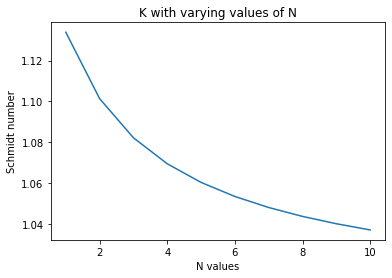

In [6]:
plt.title("K with varying values of N")
plt.xlabel("N values")
plt.ylabel("Schmidt number")
plt.plot(np.linspace(1,10,10),K_gauss)

In [7]:
jnp.sqrt(opt.get_euclidean_loss_K(optimized_pump[-1], N, alpha, G, H, l, y_K))+1

DeviceArray(1.0369115, dtype=float32)

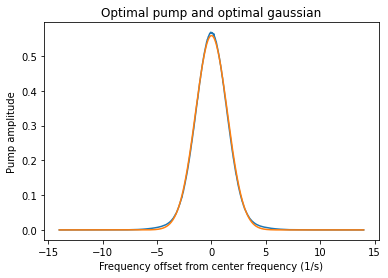

In [9]:
plt.title("Optimal pump and optimal gaussian")
plt.xlabel("Frequency offset from center frequency (1/s)")
plt.ylabel("Pump amplitude")
plt.plot(w, np.abs(complex_optimized_pump[-1]), label = "optimal pump")
plt.plot(w, np.abs(complex_opt_gauss[-1]), label = "optimal gaussian")
plt.savefig("N_10_gauss__opt_pump.png")

In [11]:
normalized_pump = complex_optimized_pump[-1]/np.linalg.norm(complex_optimized_pump[-1])
normalized_gauss = complex_opt_gauss[-1]/np.linalg.norm(complex_opt_gauss[-1])
np.abs(np.vdot(normalized_pump, normalized_gauss))

0.9997900444074865

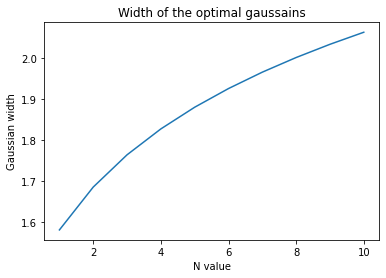

In [57]:
bandwidth = (optimized_thetas.T)[1]
domain = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.title("Width of the optimal gaussains")
plt.xlabel("N value")
plt.ylabel("Gaussian width")
plt.plot(domain, 1/bandwidth)
plt.savefig("gauss_width.png")

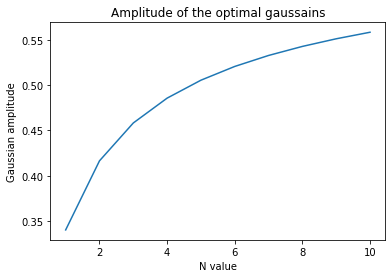

In [58]:
amplitude = (optimized_thetas.T)[0]
plt.title("Amplitude of the optimal gaussains")
plt.xlabel("N value")
plt.ylabel("Gaussian amplitude")
plt.plot(domain, amplitude)
plt.savefig("gauss_amplitude.png")

In [24]:
amplitude

array([0.33999893, 0.41639772, 0.45828125, 0.4857618 , 0.5055977 ,
       0.5208017 , 0.5329514 , 0.5429549 , 0.551387  , 0.55862445],
      dtype=float32)